In [5]:
#imports
%matplotlib inline
import base64
import sys
import time
import pyvisa
from time import sleep
from toptica.lasersdk.client import Client, SerialConnection, UserLevel
from labjack import ljm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyqtgraph as pg
import warnings
warnings.filterwarnings("ignore")

def find_toptica_port():
    rm = pyvisa.ResourceManager("@py")
    for resource in rm.list_resources():
        if resource[0:4]=="ASRL":
            try:
                dlc_connection_port = "COM"+resource[4]
                #set up connection with DLC smart and check user level
                with Client(SerialConnection(dlc_connection_port)) as client:
                    print("Found Toptica on "+dlc_connection_port)
                    user_level = client.get('ul')
                    print(client.get('general:serial-number'))
                    dlc_smart = client.get('general:system-type')
                    print(f"Connected to: {dlc_smart}")
                    print(f"Current User Level: {user_level}")
                    return dlc_connection_port
            except:
                continue
    rm.close()


In [ ]:
#set connections to DLC smart and lock-in amplifier
lockin_address = 'GPIB::8::INSTR'
dlc_connection_port = find_toptica_port()
#lock-in sensitivity setting
sensitivity_setting = 173
#set frequency to measure at
set_frequency = 129 #GHz
time_constant = 6 #lock-in time constant setting, specifics found in SR830 manual
low_pass_filter = 1 #lock-in low pass filter slope setting, specifics found in SR830 manual

In [16]:
#set up connection with lock-in amplifier
# Make sure the USB is plugged in before the lockin is turned on!
rm = pyvisa.ResourceManager()
lockin = rm.open_resource(lockin_address)
idn = lockin.query('*IDN?')
print(f'Connected to: {idn}')

#set lock-in amplifier sensitivity
lockin.write(f'SENS {sensitivity_setting}')
lockin_sensitivity = lockin.query('SENS?')
print(f"Current Lock-in Sensitivity setting: {lockin_sensitivity}")
#set lock-in time constant setting
lockin.write(f'OFLT {time_constant}')
print(f"Current Time Constant: {lockin.query('OFLT?')}")
#set lock-in low pass filter slope
lockin.write(f'OFSL {low_pass_filter}')
print(f"Current Low Pass Filter: {lockin.query('OFSL?')}")

VisaIOError: VI_ERROR_CONN_LOST (-1073807194): The connection for the given session has been lost.

In [14]:
#turn on lasers (check emission lights)
#if lasers do not power on, check the frontkey and user level
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('laser-operation:emission-global-enable', True)
    laser_on_status = client.get('laser-operation:emission-global-enable')
    print(f'Lasers on: {laser_on_status}')
#wait 5 secs for lasers to adjust
time.sleep(1)

#set DLC Smart bias amplitude and offset to default
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('lockin:mod-out-amplitude', 2.0)
    client.set('lockin:mod-out-offset', 0.0)
#set DLC Smart bias frequency to 1000
    client.set('lockin:frequency', 1000)
    print(f"Current DLC Smart Bias Amplitude (V): {client.get('lockin:mod-out-amplitude')}")
    print(f"Current DLC Smart Bias Offset (V): {client.get('lockin:mod-out-offset')}")
    print(f"Current DLC Smart Bias Frequency (Hz): {client.get('lockin:frequency')}")

time.sleep(1)
with Client(SerialConnection(dlc_connection_port)) as client:
    client.set('frequency:frequency-set', set_frequency)
    print(f"Current DLC Smart Frequency (GHz): {client.get('frequency:frequency-act')}")

time.sleep(1)

Lasers on: True
Current DLC Smart Bias Amplitude (V): 1.999969482421875
Current DLC Smart Bias Offset (V): 0
Current DLC Smart Bias Frequency (Hz): 1000
Current DLC Smart Frequency (GHz): 129.0009997805173


In [ ]:
# Window stuff
win = pg.GraphicsLayoutWidget(show=True)
win.setWindowTitle('pyqtgraph example: Scrolling Plots')
p1 = win.addPlot()
p1.setDownsampling(mode='peak')
p1.showGrid(x=True, y=True)
p1curve = p1.plot(pen=(0,255,255))
win.nextRow()
p2 = win.addPlot()
p2.setDownsampling(mode='peak')
p2.showGrid(x=True, y=True)
p2curve = p2.plot(pen=(0,255,255))
win.nextRow()
p3 = win.addPlot()
p3.setDownsampling(mode='peak')
p3.showGrid(x=True, y=True)
p3curve = p3.plot(pen=(0,255,255))

handle = ljm.openS("ANY", "ANY", "ANY")  # Any device, Any connection, Any identifier

info = ljm.getHandleInfo(handle)
print("Opened a LabJack with Device type: %i, Connection type: %i,\n"
      "Serial number: %i, IP address: %s, Port: %i,\nMax bytes per MB: %i" %
      (info[0], info[1], info[2], ljm.numberToIP(info[3]), info[4], info[5]))

names = ["AIN0"]
samp_rate = 12 # Samples per second
runtime = 5 # in seconds
#Init dataframe 
data = {'Time (Datenum)': [], 'Temp (K)': [], 'Lock-in Amp (microvolts)': [],}
dnames = data.keys()

tstart = time.time()
def update1():
    global data
    tloop = time.time()
    Ttemp = []
    Ltemp = []
    ttemp = []
    while np.abs(time.time()-tloop)<1/samp_rate:
        ttemp.append(time.time())
        Ttemp.append(ljm.eReadName(handle, names[0]))
        Ltemp.append(float(lockin.query('OUTP?1')) * 1e6)

    data['Time (Datenum)'].append(float(np.median(ttemp)))
    data['Temp (K)'].append(float(np.median(Ttemp)))
    data['Lock-in Amp (microvolts)'].append(float(np.median(Ltemp)))
    p1curve.setData(np.array(data['Time (Datenum)'])-tstart,data['Temp (K)'])
    p2curve.setData(np.array(data['Time (Datenum)'])-tstart,data['Lock-in Amp (microvolts)'])
    p3curve.setData(data['Temp (K)'],data['Lock-in Amp (microvolts)'])

# update all plots
def update():
    update1()

timer = pg.QtCore.QTimer()
timer.timeout.connect(update)
timer.start(50)

if __name__ == '__main__':
    pg.exec()

    # Close handle
    ljm.close(handle)


In [43]:
df = pd.DataFrame(data)
#df = df.drop(index = 0)
csv_file = 'C:/Users/jcornelison/Documents/GitHub/PROWLS-Control/Data/Temp_Dependence_with_heater/Tables/mirror_alignment_2024dec17.csv'
df.to_csv(csv_file, index = False)
#log_and_print(f"The data has been saved to {csv_file}, previous file may have been overwritten.")
pd.read_csv(csv_file)

Time (Datenum)  Temp (K)  Lock-in Amp (microvolts)
0         1.726776e+09  0.227680                 137.46800
1         1.726776e+09  0.227759                 136.77500
2         1.726776e+09  0.227759                 136.86400
3         1.726776e+09  0.227759                 136.64050
4         1.726776e+09  0.227680                 136.71200
...                ...       ...                       ...
100143    1.726838e+09  0.225470                  88.15570
100144    1.726838e+09  0.225470                  87.49265
100145    1.726838e+09  0.225470                  87.06800
100146    1.726838e+09  0.225470                  87.75340
100147    1.726838e+09  0.225470                  88.62510

[100148 rows x 3 columns]

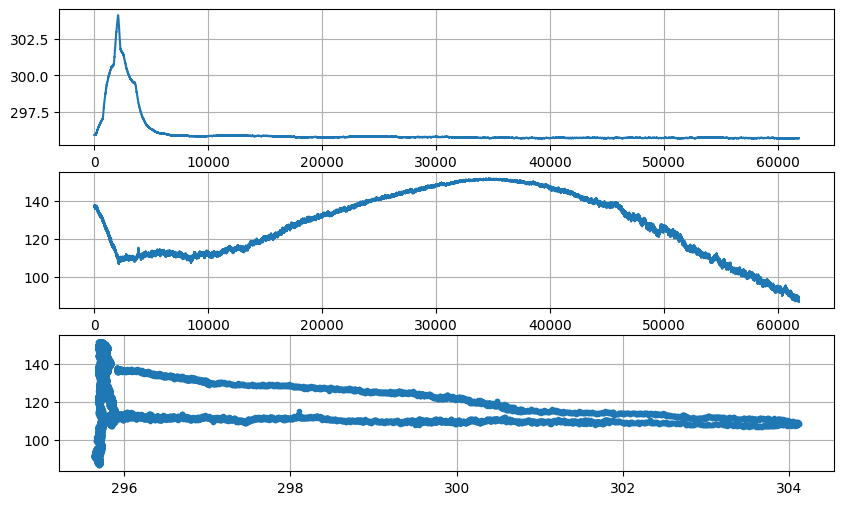

In [49]:
kys = df.keys();
plt.figure(1,figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(df[kys[0]]-df[kys[0]][0],df[kys[1]]*100+273.15)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(df[kys[0]]-df[kys[0]][0],df[kys[2]])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(df[kys[1]]*100+273.15,df[kys[2]],'.')
plt.grid(True)

plt.show()

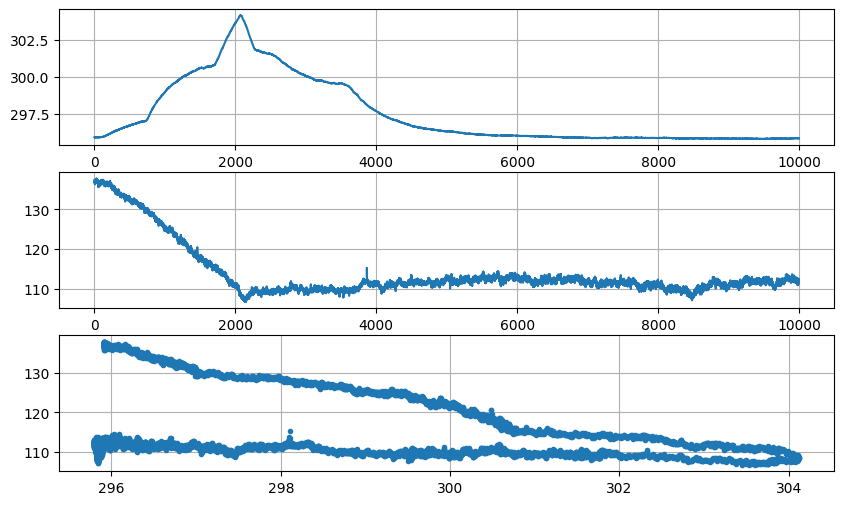

In [50]:
kys = df.keys();
t0 = df[kys[0]][0]
idx = df[kys[0]]-t0 < 1e4
plt.figure(2,figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(df[kys[0]][idx]-t0,df[kys[1]][idx]*100+273.15)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(df[kys[0]][idx]-t0,df[kys[2]][idx])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(df[kys[1]][idx]*100+273.15,df[kys[2]][idx],'.')
plt.grid(True)

plt.show()